# The Wasserstein distance as a hydrological objective function

### Jared Magyar & Malcolm Sambridge

Last Updated: October 2022

In [1]:
import numpy as np
from Wasserstein import densities as ds
from Wasserstein import hydro_models as hm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, expon
from scipy.optimize import Bounds

## Example Transport Map

We will first give an illustrative example of optimal transport for a pair of univariate Gaussian mixture models. Below, the mixtures are defined and plotted.

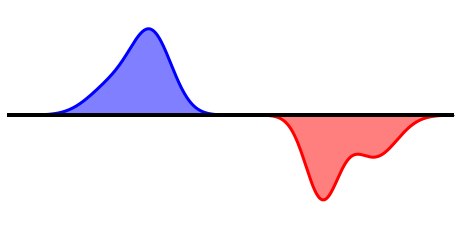

In [2]:
x = np.linspace(-2,15,500)
f = 0.3 * multivariate_normal.pdf(x,mean=2,cov=0.8) + 0.7 * multivariate_normal.pdf(x,mean=3.5,cov=0.6)
g = 0.6 * multivariate_normal.pdf(x,mean=10,cov=0.4) + 0.4 * multivariate_normal.pdf(x,mean=12,cov=0.7)


fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,f,'-b',lw=3)
ax.plot(x,-g,'-r',lw=3)
ax.fill_between(x,f,0,color='blue',alpha=0.5)
ax.fill_between(x,-g,0,color='red',alpha=0.5)
ax.plot((-2,15),(0,0),'-k',lw=4)
ax.set_xlim((-2,15))
ax.set_ylim((-0.5,0.5))
ax.axis('off')

plt.savefig('Figures/pile_hole.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/pile_hole.png',bbox_inches='tight',dpi=400)

To find the transport map, we use the univariate inverse CDF method, given by

$$
T^\ast (x) = G^{-1}\left[ F(x) \right]
$$

This gives the transport map represented by the black line below.

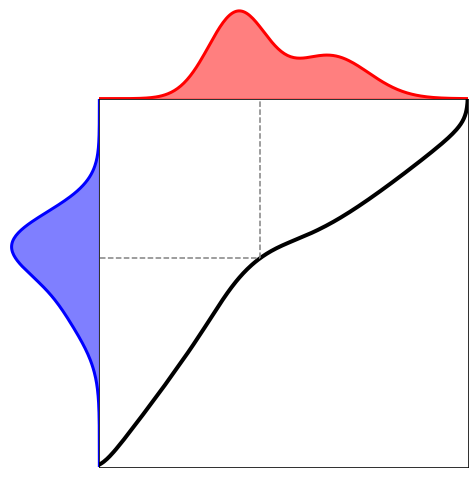

In [3]:
fd = ds.Density1D(x,f)
gd = ds.Density1D(x,g)

Tx = gd.inv_cdf(fd.F)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2,  width_ratios=(1, 4), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 1])
ax_x1 = fig.add_subplot(gs[0, 1], sharex=ax)
ax_x2 = fig.add_subplot(gs[1, 0], sharey=ax)
    
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

ax.plot(Tx,x,'-k',lw=4)
ax.set_xlim((7,15))
ax.set_ylim((-2,7))

ax_x1.plot(gd.x,gd.f,color='red',lw=3)
ax_x1.axes.yaxis.set_visible(False)
ax_x1.set_ylim(bottom=0)
ax_x1.set_xticks([])
ax_x1.fill_between(x,gd.f,0,color='red',alpha=0.5)
ax_x1.axis('off')

    
ax_x2.plot(fd.f,fd.x,color='blue',lw=3)
ax_x2.invert_xaxis()
ax_x2.axes.xaxis.set_visible(False)
ax_x2.set_xlim(right=0)
ax_x2.set_yticks([])
ax_x2.fill_betweenx(fd.x,fd.f,0,color='blue',alpha=0.5)
ax_x2.axis('off')

ax.hlines(fd.x[150],xmin=Tx[0],xmax=Tx[150],color='grey',linestyle='--')
ax.vlines(gd.inv_cdf(fd.F[150]),ymin=x[150],ymax=x[-1],color='grey',linestyle='--')

plt.savefig('Figures/transport_map.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/transport_map.png',bbox_inches='tight',dpi=400)

For one-dimensional densities, we also have a simple way of computing the Wasserstein distance from this analytical transport map. The distance is given by

$$
\mathcal{W}_2^2 (f,g) = \int_0^1 \left[ F^{-1}(t) - G^{-1}(t) \right]^2\; dt
$$

The steps for calculating 1D 2-Wasserstein distance is shown in the below figure.

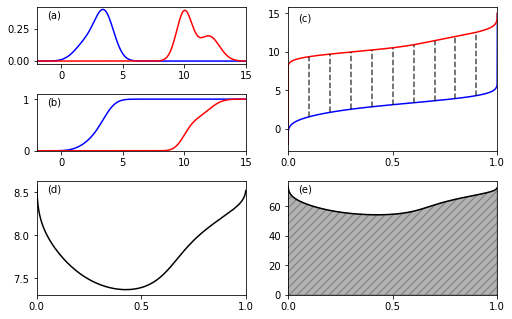

In [4]:
x = np.linspace(-2,15,500)

f = 0.3 * multivariate_normal.pdf(x,mean=2,cov=0.8) + 0.7 * multivariate_normal.pdf(x,mean=3.5,cov=0.6)
g = 0.6 * multivariate_normal.pdf(x,mean=10,cov=0.4) + 0.4 * multivariate_normal.pdf(x,mean=12,cov=0.7)

fd = ds.Density1D(x,f)
gd = ds.Density1D(x,g)

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(3, 2, height_ratios=(1, 1, 2), width_ratios=(1,1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.4)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(fd.x,fd.f,color='blue')
ax1.plot(gd.x,gd.f,color='red')
ax1.set_xlim([np.min(fd.x),np.max(fd.x)])

ax1.annotate('(a)',xy=(0.05,0.8),xycoords='axes fraction')

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(fd.x,fd.F,color='blue')
ax2.plot(gd.x,gd.F,color='red')
ax2.set_ylim([0,1.1])
ax2.set_xlim([np.min(fd.x),np.max(fd.x)])


ax2.annotate('(b)',xy=(0.05,0.8),xycoords='axes fraction')


ax3 = fig.add_subplot(gs[0:2,1])

t = np.linspace(0,1,1000)
inv1 = fd.inv_cdf(t)
inv2 = gd.inv_cdf(t)
ax3.plot(t,inv1,color='blue')
ax3.plot(t,inv2,color='red')
ax3.annotate('(c)',xy=(0.05,0.9),xycoords='axes fraction')


dot = np.linspace(0,1,11)
end_inv1 = np.interp(dot,fd.F,x)
end_inv2 = np.interp(dot,gd.F,x)

dot_max = np.maximum(end_inv1,end_inv2)
dot_min = np.minimum(end_inv1,end_inv2)

    
ax3.vlines(x=dot,ymin=dot_min,ymax=dot_max,linestyle='--',color='black',alpha=0.7)
ax3.set_xlim([0,1])
ax3.set_xticks([0,0.5,1])

invdif = (inv2 - inv1)[1:-1]

ax4 = fig.add_subplot(gs[2,0])
ax4.plot(t[1:-1],invdif,color='black')
ax4.set_xlim([0,1])
ax4.annotate('(d)',xy=(0.05,0.9),xycoords='axes fraction')
ax4.set_xticks([0,0.5,1])

ax5 = fig.add_subplot(gs[2,1])
int_reg = invdif**2
ax5.plot(t[1:-1],int_reg,color='black')
ax5.fill_between(t[1:-1],int_reg,color='black',alpha=0.3,hatch='///')
ax5.set_xlim([0,1])
ax5.set_ylim(bottom=0)
ax5.annotate('(e)',xy=(0.05,0.9),xycoords='axes fraction')
ax5.set_xticks([0,0.5,1])

plt.savefig('Figures/1D_Wasserstein.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/1D_Wasserstein.png',bbox_inches='tight',dpi=400)

## Wasserstein Barycenters

Optimal transport provides an intuitive definition of 'average' for density functions, known as the Wasserstein barycenter. This has a simple analytical form for univariate densities, given by

$$
F^{-1}(s) = \sum_{i=1}^n \lambda_i G_i^{-1}(s), \quad s\in[0,1]
$$

where $\lambda_i$ is the weighting of the $i$-th density function, and we must have $\sum_i \lambda_i = 1$. The below figures show these barycenters and how they are computed for Gaussian densities.

In [5]:
def Model(x,m,*args):
    f = m[0] * multivariate_normal.pdf(x,mean=m[1],cov=m[2]**2)
    return f

def Derivs(x,m,*args):
    f = Model(x,m)
    df_dw = f / m[0]
    df_dmu = (x - m[1]) / m[2]**2 * f
    df_dsig = f * (-1/m[2] + (x-m[1])**2/m[2]**3)
    return np.array((df_dw,df_dmu,df_dsig))

x = np.linspace(-10,10,100) #points at which forward model will be solved
Gaussian = ds.Model1D(x,Model,deriv=Derivs) #collect all of these into forward model object

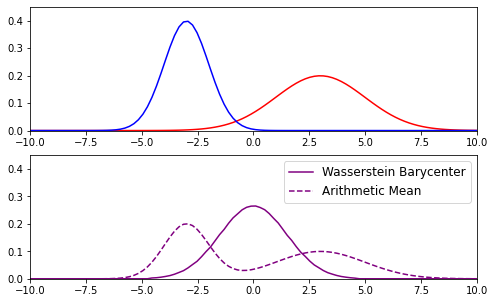

In [6]:
dens_lst = [Gaussian.density([1,3,2]),Gaussian.density([1,-3,1])]

fig, ax = plt.subplots(nrows=2,figsize=(8,5))

ax[0].plot(x,dens_lst[0].f,'-r')
ax[0].plot(x,dens_lst[1].f,'-b')
ax[0].set_xlim((-10,10))
ax[0].set_ylim((0,0.45))


ax[1].plot(x,ds.Barycentre1D(dens_lst).f,color='purple',label='Wasserstein Barycenter')
ax[1].plot(x,(dens_lst[0].f+dens_lst[1].f)/2,ls='--',color='purple',label='Arithmetic Mean')
ax[1].set_xlim((-10,10))
ax[1].set_ylim((0,0.45))

ax[1].legend(fontsize=12)

plt.savefig('Figures/gaussian_barycenter.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/gaussian_barycenter.png',bbox_inches='tight',dpi=400)

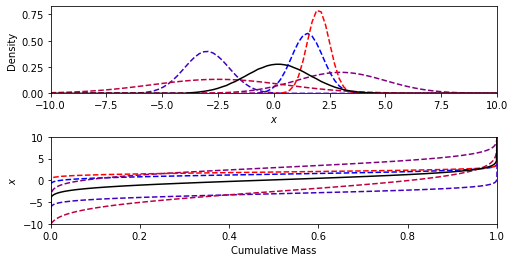

In [7]:
dens_lst = [Gaussian.density([1,1.5,0.7]),Gaussian.density([1,-3,1]),Gaussian.density([1,3,2]),Gaussian.density([1,-2.5,3]),Gaussian.density([1,2,0.5])]
            
fig, ax = plt.subplots(nrows=2,figsize=(8,4))
for i, dens in enumerate(dens_lst):
    ax[0].plot(dens.x,dens.f,color=(i/4,0,(4-i)/4),ls='--')
    ax[1].plot(dens.F,dens.x,color=(i/4,0,(4-i)/4),ls='--')
    
ax[0].plot(dens_lst[0].x,ds.Barycentre1D(dens_lst).f,color='black')
ax[1].plot(ds.Barycentre1D(dens_lst).F,dens_lst[0].x,color='black')

ax[0].set_xlim((-10,10))
ax[0].set_ylim(bottom=0)
ax[1].set_xlim((0,1))
ax[1].set_ylim((-10,10))

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Density')
ax[1].set_xlabel('Cumulative Mass')
ax[1].set_ylabel(r'$x$')

plt.subplots_adjust(hspace=0.5)
plt.savefig('Figures/barycenter_method.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/barycenter_method.png',bbox_inches='tight',dpi=400)

## Misfit Comparison

Before hydrological examples are presented, a simple parameter estimation for scaled Gaussian distributions is given to demonstrate the inversion code. Firstly, we need to define our forward model. This will have three model parameters: the amplitude, weight, and standard deviation. We can also find derivatives of this model analytically. If this is not the case, some type of finite differencing scheme can take the place of the derivative function. 

For this initial test, we will use synthetic data produced by the forward model with known parameters. 

In [8]:
g = Model(x,[1,0,1]) #generate synthetic data by running the forward model
gd = ds.Density1D(x,g) #convert this to a density object which will be an input to the inversion

We can now compare the misfit surfaces for the 2-Wasserstein distance and the L2-norm.

In [9]:
W2 = np.zeros([101]) #initialise the W2 misfit surface
L2 = np.zeros([101]) #initialise the L2 misfit surface

mu_test = np.linspace(-5,5,101)

for i,mu in enumerate(mu_test):
    W2[i] = ds.Objective([1,mu,1],Gaussian,gd,gamma=0) #compute J(m)
    L2[i] = ds.L2([1,mu,1],Gaussian,gd)

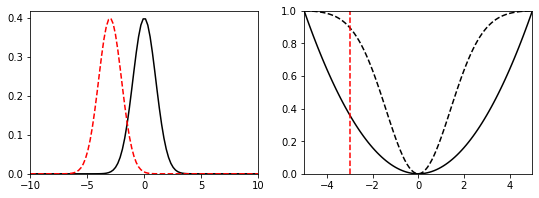

In [10]:
W2 /= np.max(W2)
L2 /= np.max(L2)

fig, ax = plt.subplots(ncols=2,figsize=(9,3))

ax[0].plot(gd.x,gd.f,'-k')
ax[0].plot(gd.x,Gaussian([1,-3,1]),'--r')
ax[0].set_xlim((-10,10))
ax[0].set_ylim(bottom=0)

ax[1].plot(mu_test,W2,'-k',label=r'$W_2^2$')
ax[1].plot(mu_test,L2,'--k',label=r'$L_2$')
ax[1].vlines(-3,ymin=0,ymax=1,color='red',ls='--')
ax[1].set_xlim((-5,5))
ax[1].set_ylim((0,1))
plt.show()

In [11]:
x = np.linspace(-15,15,100) #points at which forward model will be solved
Gaussian = ds.Model1D(x,Model,deriv=Derivs) #collect all of these into forward model object

g = Model(x,[2,0,1]) #generate synthetic data by running the forward model
gd = ds.Density1D(x,g) #convert this to a density object which will be an input to the inversion

In [12]:
W2_l = np.zeros([50,50]) #initialise the W2 misfit surface
W2_d = np.zeros([50,50])
L2 = np.zeros([50,50]) #initialise the L2 misfit surface

w_test = np.linspace(0.1,5,50)
mu_test = np.linspace(-5,5,50)

for i,w in enumerate(w_test):
    for j,mu in enumerate(mu_test):
        W2_d[i,j] = ds.Objective([w,mu,1],Gaussian,gd,gamma=5,penalty='diff') #compute J(m)
        W2_l[i,j] = ds.Objective([w,mu,1],Gaussian,gd,gamma=5,penalty='log') #compute J(m)
        L2[i,j] = ds.L2([w,mu,1],Gaussian,gd)

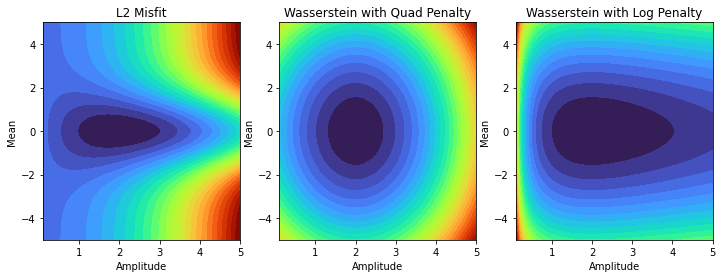

In [13]:
#plot the misfit surfaces

fig, ax = plt.subplots(ncols=3,figsize=(12,4))

ax[0].contourf(w_test,mu_test,L2.T,levels=30,cmap='turbo')
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Mean')
ax[0].set_title('L2 Misfit')

ax[1].contourf(w_test,mu_test,W2_d.T,levels=30,cmap='turbo')
ax[1].set_xlabel('Amplitude')
ax[1].set_ylabel('Mean')
ax[1].set_title('Wasserstein with Quad Penalty')

ax[2].contourf(w_test,mu_test,W2_l.T,levels=30,cmap='turbo')
ax[2].set_xlabel('Amplitude')
ax[2].set_ylabel('Mean')
ax[2].set_title('Wasserstein with Log Penalty')

plt.show()

We can see that the $L^2$ becomes insensitive to the mean when the peaks no longer overlap. The Wasserstein distance does not have this property, as it makes a global comparison, so yields a better optimisation surface.

We can now test our optimisation algorithm. Here, we minimise $J(\mathbf{m})$ using the BFGS algorithm, implemented through the scipy library.

In [14]:
fit = ds.Invert_Scale(Gaussian,np.array([5,6,5]),gd,gamma=10) #run the inversion function
m = fit.x
J = fit.fun
its = fit.nit

print('Model Parameters: \n Amplitude: {:.3f} \n Mean: {:.3f} \n Standard Deviation {:.3f}'.format(m[0],m[1],m[2]))
print('Final Misfit: {:.3e}'.format(J))
print('Number of iterations: {:}'.format(its))

Model Parameters: 
 Amplitude: 2.000 
 Mean: 0.000 
 Standard Deviation 1.000
Final Misfit: 2.736e-12
Number of iterations: 12


Note that this is a very simple optimisation problem, and the power of the Wasserstein distance is more apparent in complex inversions. However, this helps confirm the validity of the derivations made so far, and is a good test case for implementing 1D techniques. Indeed, we can see the presence of local minima in the L2 misfit surface when using a double-Gaussian model, as shown below.

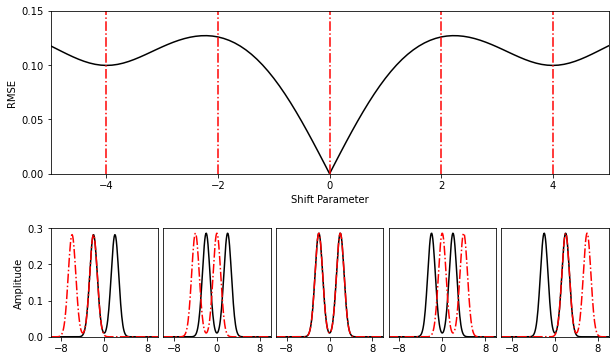

In [15]:
def DoubleModel(x,m,*args):
    f = 0.5 * multivariate_normal.pdf(x,mean=m[0]-2,cov=0.5) + 0.5 * multivariate_normal.pdf(x,mean=m[0]+2,cov=0.5)
    return f


x = np.linspace(-10,10,200) #points at which forward model will be solved
DoubleGaussian = ds.Model1D(x,DoubleModel) #collect all of these into forward model object


g = DoubleModel(x,np.array([0])) #generate synthetic data by running the forward model
gd = ds.Density1D(x,g) #convert this to a density object which will be an input to the inversion

W2 = np.zeros([101]) #initialise the W2 misfit surface
RMSE = np.zeros([101]) #initialise the L2 misfit surface

mu_test = np.linspace(-5,5,101)

for i,mu in enumerate(mu_test):
    W2[i] = ds.Objective(np.array([mu]),DoubleGaussian,gd,gamma=0) 
    RMSE[i] = np.sqrt(ds.L2(np.array([mu]),DoubleGaussian,gd) / g.size)
    
W2 /= np.max(W2)

fig = plt.figure(figsize=(10,6))

gs = fig.add_gridspec(nrows=2,ncols=5,height_ratios=(1.5,1),wspace=0.05,hspace=0.4)

ax0 = fig.add_subplot(gs[0,:])

#ax0.plot(mu_test,W2,'-k',label=r'$W_2^2$')
ax0.plot(mu_test,RMSE,'-k',label=r'$L_2$')
ax0.set_xlim((-5,5))
ax0.set_ylim(bottom=0)
ax0.set_xlabel('Shift Parameter')
ax0.set_ylabel('RMSE')
ax0.set_yticks([0,0.05,0.1,0.15])

bottom = []
shift = [-4,-2,0,2,4]
for i in range(5):
    bottom.append(fig.add_subplot(gs[1,i]))

    bottom[i].plot(gd.x,gd.f,'-k')
    bottom[i].set_xlim((-10,10))
    bottom[i].set_ylim(bottom=0)
    
    bottom[i].plot(x,DoubleModel(x,np.array([shift[i]])),color='red',ls='-.')
    ax0.vlines(shift[i],ymin=0,ymax=1,color='red',ls='-.')
    
    bottom[i].set_xticks([-8,0,8])
    bottom[i].set_yticks([])

    
bottom[0].set_ylabel('Amplitude')
bottom[0].set_yticks([0,0.1,0.2,0.3])
plt.savefig('Figures/double_gauss_shift.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/double_gauss_shift.png',bbox_inches='tight',dpi=400)

However, if we use the 2-Wasserstein distance, the misfit surface becomes convex and suitable for local optimisation with an arbitrary starting point. 

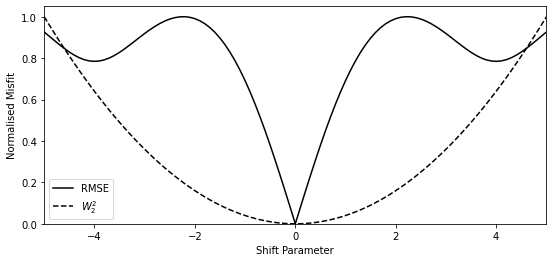

In [16]:
fig, ax = plt.subplots(figsize=(9,4))

RMSE_s = RMSE / np.max(RMSE)

ax.plot(mu_test,RMSE_s,'-k',label='RMSE')
ax.plot(mu_test,W2,'--k',label=r'$W_2^2$')
ax.set_xlim((-5,5))
ax.set_ylim(bottom=0)
ax.legend()

ax.set_xlabel('Shift Parameter')
ax.set_ylabel('Normalised Misfit')

plt.savefig('Figures/double_gauss_comp.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/double_gauss_comp.png',bbox_inches='tight',dpi=400)

## Rainfall-Runoff Modelling

We will now consider the calibration of rainfall-runoff models. These require us to fit the output of a hydrological model to the observed stream discharge. There are issues with amplitude-based misfit measures where there are timing errors in peak flows, and the misfit is overestimated.

We will propose that the Wasserstein distance gives an alternative misfit measure that accounts for timing errors more appropriately. This comes at the cost of more difficulty in ensuring mass balance between the model and observations due to the requisite rescaling to unit mass. 

One way around this is to use the penalty term for total mass differences, which gives a multi-objective approach. Multiple objectives are commonly used in hydrology, and this would be a familiar approach for this application. A second route would be to modify the definition of OT to allow the unit mass constraint to be violated. This second approach would be preferred as it would negate the need to pick weighting parameters and a correct form for the mass balance penalty term.

### Unit Hydrograph Inversion

A simple model we will use as an initial test case here is the instantaneous unit hydrograph (IUH). While simple, this model can generate timing errors, so is a candidate for Wasserstein-based experiments. Note that it is not a complex model, and there are a variety of alternate ways to estimate the parameters. However, we can explore some of the characteristics of more complex models through it. 

The IUH converts effective rainfall into measured streamflow via a convolution. 

$$ q(t) = r(t) \ast u(t) = \int_0^t u(t-s) r(s) ds $$

For the following experiments, we will assume that the IUH is of the form proposed by Nash with an additional scaling term.

$$ u(t) = \frac{a}{\Gamma(k)\theta^k}t^{k-1}e^{-t/\theta} $$

This rescaled Gamma density function represents a series of $k$ reservoirs with residence time $\theta$. To set-up the parameter estimation problem, we will measure the streamflow $q$, the effective rainfall $r$ and attempt to estimate $a$, $\theta$, and $k$.

### Hydrograph-Wasserstein Distance Visualisation

The Wasserstein distance is defined for densities of equal mass. We cannot be sure that two hydrographs will be of equal mass, so must generalise the metric. A simple penalty term can be added, or a modification made to how the Wasserstein distance is computed. Both approaches are considered in the paper. For the second option, the Hydrograph-Wasserstein distance (equation 20 in paper) is developed, and visualised in the below figures.

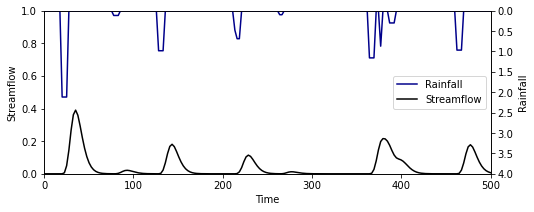

In [17]:
#np.random.seed(seed=456748612)

np.random.seed(seed=452118)


t = np.linspace(0,500,200)
r,r_n = hm.Simple_Rain(200,10)
UH = hm.HydroModel(t,hm.Unit_Hydrograph)

obs = UH(np.array([3,5]),r)

fig, ax = plt.subplots(figsize=(8,3))

stream_plot = ax.plot(t,obs.q,'-k',label='Streamflow')

ax2 = ax.twinx()
ax2.invert_yaxis()

rain_plot = ax2.plot(t,r,color='darkblue',label='Rainfall')
ax2.set_ylim((4,0))

ax.set_ylim((0,1))

ax.set_xlim((0,500))

ax.set_xlabel('Time')
ax.set_ylabel('Streamflow')
ax2.set_ylabel('Rainfall')

labs = [rain_plot[0].get_label(), stream_plot[0].get_label()]
ax.legend([rain_plot[0],stream_plot[0]], labs,loc=5)

plt.savefig('Figures/iuh_rainfall.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/iuh_rainfall.png',bbox_inches='tight',dpi=400)

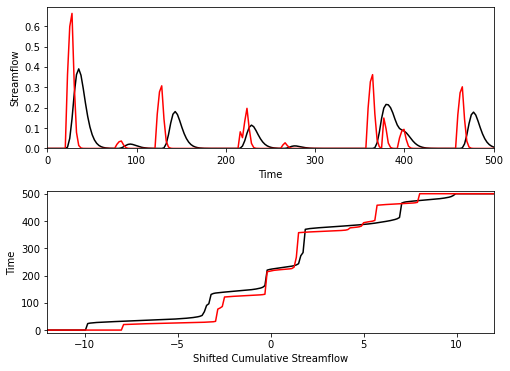

In [18]:
obs2 = UH(np.array([1,4]),0.8*r_n)

s = np.linspace(-12,12,200)
T1 = obs.inv_time(s)
T2 = obs2.inv_time(s)

fig, ax = plt.subplots(nrows=2,figsize=(8,6))

ax[0].plot(obs.t,obs.q,'-k')
ax[0].plot(obs2.t,obs2.q,'-r')
ax[0].set_xlim((0,500))
ax[0].set_ylim(bottom=0)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Streamflow')

ax[1].plot(s,T1,'-k')
ax[1].plot(s,T2,'-r')
ax[1].set_ylim((-10,510))
ax[1].set_xlim((-12,12))
ax[1].set_xlabel('Shifted Cumulative Streamflow')
ax[1].set_ylabel('Time')

plt.subplots_adjust(hspace=0.3)

plt.savefig('Figures/HW_expl.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/HW_expl.png',bbox_inches='tight',dpi=400)

The usefulness of the Wasserstein distance becomes apparent when we see the behaviour of the point-wise residuals for changes in model parameters that alter peak flow timing.

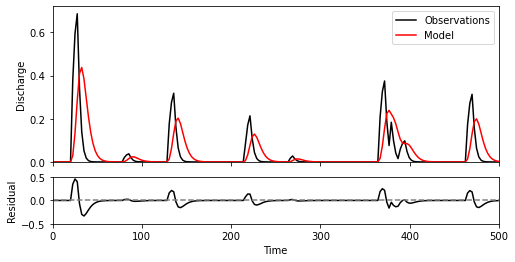

In [19]:
obs1 = UH(np.array([2,2]),r)
obs2 = UH(np.array([3,4]),r)


fig, ax = plt.subplots(nrows=2,figsize=(8,4),sharex=True,gridspec_kw={'height_ratios':[1,0.3]})
ax[0].plot(t,obs1.q,'-k',label='Observations')
ax[0].plot(t,obs2.q,'-r',label='Model')
ax[0].set_xlim((0,500))
ax[0].set_ylim(bottom=0)
ax[0].set_ylabel('Discharge')
ax[0].legend()

ax[1].plot(t,obs1.q-obs2.q,'-k')
ax[1].hlines(0,xmin=0,xmax=500,ls='--',color='grey')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Residual')
ax[1].set_ylim((-0.5,0.5))

plt.subplots_adjust(hspace=0.15)

plt.savefig('Figures/hydrograph_res.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/hydrograph_res.png',bbox_inches='tight',dpi=400)

Studying the misfit surfaces can give an insight on the behaviour of the chosen misfit function.

In [20]:
RMSE = np.zeros([51,51]) #initialise the L2 misfit surface
W2 = np.zeros([51,51])

RMSE_opt = np.zeros([51,51])
W2_opt = np.zeros([51,51])

theta_test = np.linspace(0.5,15.1,51)
k_test = np.linspace(1.5,12.1,51)

bounds = Bounds(np.array([1e-5,1+1e-5]),np.array([np.inf,np.inf]),keep_feasible=True)

for i,theta in enumerate(theta_test):
    for j,k in enumerate(k_test):
        sim = UH([theta,k],r)
        W2[i,j] = hm.Wasserstein(obs,sim,gamma=100)
        RMSE[i,j] = np.sqrt(np.sum((sim.q - obs.q)**2)/sim.N)
        
        RMSE_opt[i,j] = hm.Fit_Hydrograph(obs,r,UH,np.array([theta,k]),misfit='RMSE',method='L-BFGS-B',bounds=bounds).fun
        W2_opt[i,j] = hm.Fit_Hydrograph(obs,r,UH,np.array([theta,k]),misfit='W2',method='L-BFGS-B',gamma=100,bounds=bounds).fun

/Users/jmagyar/Dropbox/Summer Work/Code/Wasserstein/hydro_models.py:171: OptimizeWarning: Unknown solver options: xatol, fatol
  result = minimize(obj,m0,args=(model,obs,r,res,gamma),bounds=bounds,method=method,options={'maxiter':10000,'xatol':1e-6,'fatol':1e-6})
/Users/jmagyar/Dropbox/Summer Work/Code/Wasserstein/hydro_models.py:282: RuntimeWarning: overflow encountered in double_scalars
  u = t**(k-1) * np.exp(-t/theta) / (gamma(k)*theta**k)
/Users/jmagyar/Dropbox/Summer Work/Code/Wasserstein/hydro_models.py:282: RuntimeWarning: invalid value encountered in true_divide
  u = t**(k-1) * np.exp(-t/theta) / (gamma(k)*theta**k)
/Users/jmagyar/Dropbox/Summer Work/Code/Wasserstein/hydro_models.py:282: RuntimeWarning: overflow encountered in power
  u = t**(k-1) * np.exp(-t/theta) / (gamma(k)*theta**k)
/Users/jmagyar/Dropbox/Summer Work/Code/Wasserstein/hydro_models.py:282: RuntimeWarning: invalid value encountered in multiply
  u = t**(k-1) * np.exp(-t/theta) / (gamma(k)*theta**k)
/Users/j

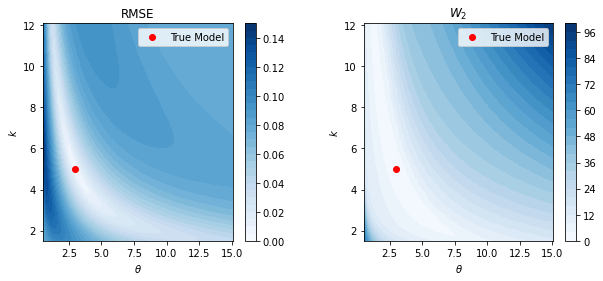

In [21]:
fig, ax = plt.subplots(ncols=2,figsize=(10,4))
cRMSE = ax[0].contourf(theta_test,k_test,RMSE.T,cmap='Blues',levels=30)
cW2 = ax[1].contourf(theta_test,k_test,np.sqrt(W2).T,cmap='Blues',levels=30)

plt.colorbar(cRMSE,ax=ax[0])
plt.colorbar(cW2,ax=ax[1])


for i in range(2):
    ax[i].set_xlabel(r'$\theta$')
    ax[i].set_ylabel(r'$k$')
    ax[i].plot(3,5,'or',label='True Model')
    ax[i].legend()
    
    
ax[0].set_title('RMSE')
ax[1].set_title(r'$W_{2}$')

plt.subplots_adjust(wspace=0.35)

plt.savefig('Figures/iuh_misfit.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/iuh_misfit.png',bbox_inches='tight',dpi=400)

### Simple Hydrological Model

We can now look at how the Wasserstein-based distance behaves in the presence of timing errors. We generate two rainfall time series; one which is used as an input to a non-linear hydrological storage model (see Equations 21 and 22 in paper), and the other which is used as the 'observation'. 

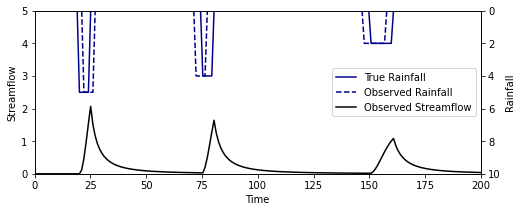

In [22]:
t = np.linspace(0,200,200)
NL = hm.HydroModel(t,hm.NonLinearHydro)

rain = np.zeros(200)
rain[20:25] = 5
rain[75:80] = 4
rain[150:160] = 2

rain_n = np.zeros(200)
rain_n[22:27] = 5
rain_n[72:77] = 4
rain_n[147:157] = 2


obs = NL([10,2,0.7],rain)


fig, ax = plt.subplots(figsize=(8,3))

stream_o = ax.plot(t,obs.q,'-k',label='Observed Streamflow')

ax2 = ax.twinx()
ax2.invert_yaxis()

rain_t = ax2.plot(t,rain,color='darkblue',label='True Rainfall')
rain_o = ax2.plot(t,rain_n,color='darkblue',ls='--',label='Observed Rainfall')
ax2.set_ylim((10,0))

ax.set_ylim((0,5))

ax.set_xlim((0,200))

ax.set_xlabel('Time')
ax.set_ylabel('Streamflow')
ax2.set_ylabel('Rainfall')

labs = [rain_t[0].get_label(),rain_o[0].get_label(),stream_o[0].get_label()]
ax.legend([rain_t[0],rain_o[0],stream_o[0]], labs,loc=5)

plt.savefig('Figures/rain_flow.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/rain_flow.png',bbox_inches='tight',dpi=400)

We now attempt to fit the model to the streamflow using the noisy rainfall observations.

In [23]:
#we can straight away find the optimal solution under each misfit function for later plotting
bounds = Bounds(np.array([5,1,0.1]),np.array([15,4,1]),keep_feasible=True)
best_RMSE = hm.Fit_Hydrograph(obs,rain_n,NL,np.array([10,2,0.7]),misfit='RMSE',method='Nelder-Mead').x
best_W2_1 = hm.Fit_Hydrograph(obs,rain_n,NL,np.array([10,2,0.7]),misfit='W2',method='Nelder-Mead',gamma=10).x
best_W2_2 = hm.Fit_Hydrograph(obs,rain_n,NL,np.array([10,2,0.7]),misfit='W2',method='Nelder-Mead',gamma=100).x
best_HW = hm.Fit_Hydrograph(obs,rain_n,NL,np.array([10,2,0.7]),misfit='HW',method='Nelder-Mead').x

true = [10,2,0.7]

/Users/jmagyar/Dropbox/Summer Work/Code/Wasserstein/hydro_models.py:398: RuntimeWarning: invalid value encountered in double_scalars
  q[i] = (V / m[0])**m[1]


In [24]:
hm.Fit_Hydrograph(obs,rain_n,NL,np.array([10,2,0.7]),misfit='HW',method='Nelder-Mead')

 final_simplex: (array([[10.436676  ,  1.8164069 ,  0.69415027],
       [10.43667672,  1.81640695,  0.69415027],
       [10.43667504,  1.81640684,  0.69415026],
       [10.43667641,  1.81640693,  0.69415027]]), array([255.89757824, 255.89757824, 255.89757824, 255.89757824]))
           fun: 255.89757824386524
       message: 'Optimization terminated successfully.'
          nfev: 262
           nit: 138
        status: 0
       success: True
             x: array([10.436676  ,  1.8164069 ,  0.69415027])

In [25]:
m1_test = np.linspace(5,15,50)
m2_test = np.linspace(1,4,50)
m3_test = np.linspace(0.1,1,50)

In [26]:
RMSE = np.zeros([50,50])
W2_1 = np.zeros([50,50])
W2_2 = np.zeros([50,50])
HW = np.zeros([50,50])

for i,m1 in enumerate(m1_test):
    for j,m2 in enumerate(m2_test):
        sim = NL([m1,m2,0.7],rain_n)
        RMSE[i,j] = np.sqrt(np.sum((sim.q - obs.q)**2)/sim.N)
        W2_1[i,j] = hm.Wasserstein(sim,obs,gamma=10)
        W2_2[i,j] = hm.Wasserstein(sim,obs,gamma=100)
        HW[i,j] = hm.Hydro_Wasserstein(sim,obs)

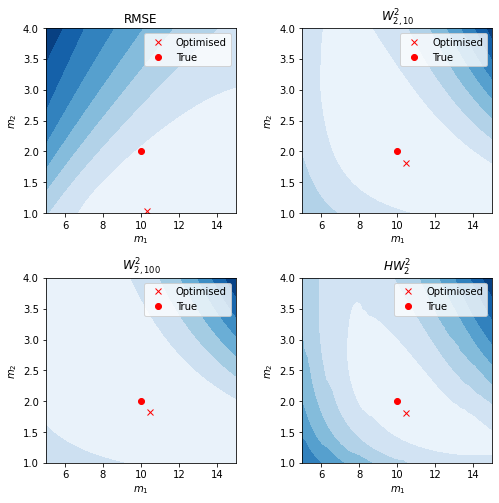

In [27]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(8,8))
ax[0,0].contourf(m1_test,m2_test,RMSE.T,cmap='Blues')
ax[0,1].contourf(m1_test,m2_test,W2_1.T,cmap='Blues')
ax[1,0].contourf(m1_test,m2_test,W2_2.T,cmap='Blues')
ax[1,1].contourf(m1_test,m2_test,HW.T,cmap='Blues')

ax[0,0].plot(best_RMSE[0],best_RMSE[1],'xr',label='Optimised')
ax[0,1].plot(best_W2_1[0],best_W2_1[1],'xr',label='Optimised')
ax[1,0].plot(best_W2_2[0],best_W2_2[1],'xr',label='Optimised')
ax[1,1].plot(best_HW[0],best_HW[1],'xr',label='Optimiosed')

for i in range(4):
    ax[i//2,i%2].plot(true[0],true[1],'or',label='True')
    ax[i//2,i%2].set_xlabel(r'$m_1$')
    ax[i//2,i%2].set_ylabel(r'$m_2$')
    ax[i//2,i%2].legend()
    
    
ax[0,0].set_title('RMSE')
ax[0,1].set_title(r'$W_{2,10}^2$')
ax[1,0].set_title(r'$W_{2,100}^2$')
ax[1,1].set_title(r'$HW_2^2$')

plt.subplots_adjust(hspace=0.35,wspace=0.35)

plt.savefig('Figures/misfit12.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/misfit12.png',bbox_inches='tight',dpi=400)

In [28]:
RMSE = np.zeros([50,50])
W2_1 = np.zeros([50,50])
W2_2 = np.zeros([50,50])
HW = np.zeros([50,50])

for i,m1 in enumerate(m1_test):
    for k,m3 in enumerate(m3_test):
        sim = NL([m1,2,m3],rain_n)
        RMSE[i,k] = np.sqrt(np.sum((sim.q - obs.q)**2)/sim.N)
        W2_1[i,k] = hm.Wasserstein(sim,obs,gamma=10)
        W2_2[i,k] = hm.Wasserstein(sim,obs,gamma=100)
        HW[i,k] = hm.Hydro_Wasserstein(sim,obs)

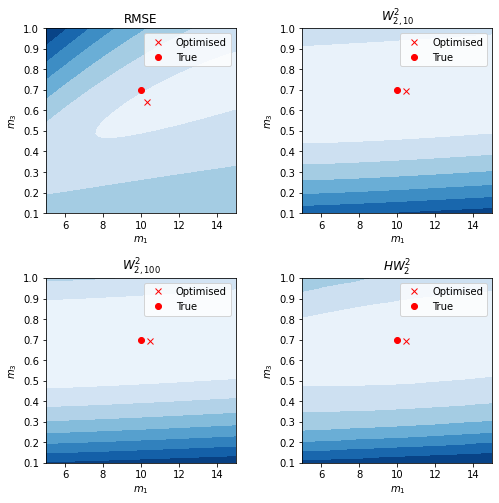

In [29]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(8,8))
ax[0,0].contourf(m1_test,m3_test,RMSE.T,cmap='Blues')
ax[0,1].contourf(m1_test,m3_test,W2_1.T,cmap='Blues')
ax[1,0].contourf(m1_test,m3_test,W2_2.T,cmap='Blues')
ax[1,1].contourf(m1_test,m3_test,HW.T,cmap='Blues')

ax[0,0].plot(best_RMSE[0],best_RMSE[2],'xr',label='Optimised')
ax[0,1].plot(best_W2_1[0],best_W2_1[2],'xr',label='Optimised')
ax[1,0].plot(best_W2_2[0],best_W2_2[2],'xr',label='Optimised')
ax[1,1].plot(best_HW[0],best_HW[2],'xr',label='Optimised')

for i in range(4):
    ax[i//2,i%2].plot(true[0],true[2],'or',label='True')
    ax[i//2,i%2].set_xlabel(r'$m_1$')
    ax[i//2,i%2].set_ylabel(r'$m_3$')
    ax[i//2,i%2].legend()
    
    
ax[0,0].set_title('RMSE')
ax[0,1].set_title(r'$W_{2,10}^2$')
ax[1,0].set_title(r'$W_{2,100}^2$')
ax[1,1].set_title(r'$HW_2^2$')

plt.subplots_adjust(hspace=0.35,wspace=0.35)

plt.savefig('Figures/misfit13.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/misfit13.png',bbox_inches='tight',dpi=400)

In [30]:
RMSE = np.zeros([50,50])
W2_1 = np.zeros([50,50])
W2_2 = np.zeros([50,50])
HW = np.zeros([50,50])

for j,m2 in enumerate(m2_test):
    for k,m3 in enumerate(m3_test):
        sim = NL([10,m2,m3],rain_n)
        RMSE[j,k] = np.sqrt(np.sum((sim.q - obs.q)**2)/sim.N)
        W2_1[j,k] = hm.Wasserstein(sim,obs,gamma=10)
        W2_2[j,k] = hm.Wasserstein(sim,obs,gamma=100)
        HW[j,k] = hm.Hydro_Wasserstein(sim,obs)

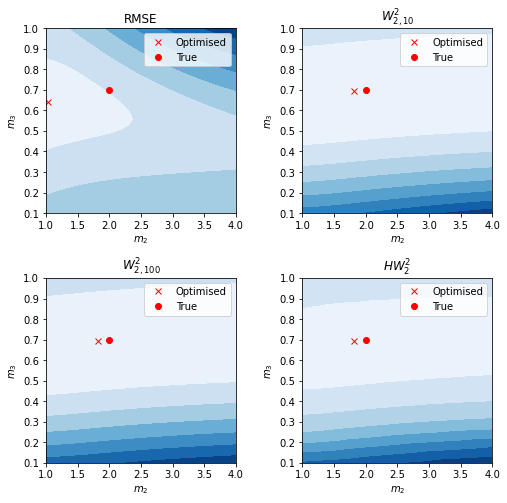

In [31]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(8,8))
ax[0,0].contourf(m2_test,m3_test,RMSE.T,cmap='Blues')
ax[0,1].contourf(m2_test,m3_test,W2_1.T,cmap='Blues')
ax[1,0].contourf(m2_test,m3_test,W2_2.T,cmap='Blues')
ax[1,1].contourf(m2_test,m3_test,HW.T,cmap='Blues')

ax[0,0].plot(best_RMSE[1],best_RMSE[2],'xr',label='Optimised')
ax[0,1].plot(best_W2_1[1],best_W2_1[2],'xr',label='Optimised')
ax[1,0].plot(best_W2_2[1],best_W2_2[2],'xr',label='Optimised')
ax[1,1].plot(best_HW[1],best_HW[2],'xr',label='Optimised')

for i in range(4):
    ax[i//2,i%2].plot(true[1],true[2],'or',label='True')
    ax[i//2,i%2].set_xlabel(r'$m_2$')
    ax[i//2,i%2].set_ylabel(r'$m_3$')
    ax[i//2,i%2].legend()
    
    
ax[0,0].set_title('RMSE')
ax[0,1].set_title(r'$W_{2,10}^2$')
ax[1,0].set_title(r'$W_{2,100}^2$')
ax[1,1].set_title(r'$HW_2^2$')

plt.subplots_adjust(hspace=0.35,wspace=0.35)

plt.savefig('Figures/misfit23.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/misfit23.png',bbox_inches='tight',dpi=400)

Below, we can see the fit for each of the chosen misfit cases.

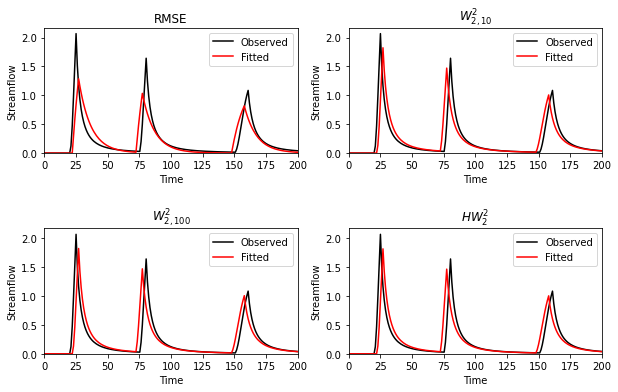

In [32]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,6))

for i in range(4):
    ax[i//2,i%2].plot(t,obs.q,'-k',label='Observed')
    ax[i//2,i%2].set_xlabel('Time')
    ax[i//2,i%2].set_ylabel('Streamflow')
    ax[i//2,i%2].set_xlim((0,200))
    ax[i//2,i%2].set_ylim(bottom=0)

ax[0,0].plot(t,NL(best_RMSE,rain_n).q,'-r',label='Fitted')
ax[0,1].plot(t,NL(best_W2_1,rain_n).q,'-r',label='Fitted')
ax[1,0].plot(t,NL(best_W2_2,rain_n).q,'-r',label='Fitted')
ax[1,1].plot(t,NL(best_HW,rain_n).q,'-r',label='Fitted')


ax[0,0].set_title('RMSE')
ax[0,1].set_title(r'$W_{2,10}^2$')
ax[1,0].set_title(r'$W_{2,100}^2$')
ax[1,1].set_title(r'$HW_2^2$')

for i in range(4):
    ax[i//2,i%2].legend()

plt.subplots_adjust(hspace=0.6)

plt.savefig('Figures/hydro_comp.pdf',bbox_inches='tight')
plt.savefig('Figures/hydro_comp.png',bbox_inches='tight')

## Hydrograph Barycenters

Wasserstein barycenters can be used to define an 'average' of probablity densities. We apply this concept to hydrographs. Below two cases are shown: one where the Wasserstein barycenter is more suitable, and one where the arithmetic mean is more suitable. 

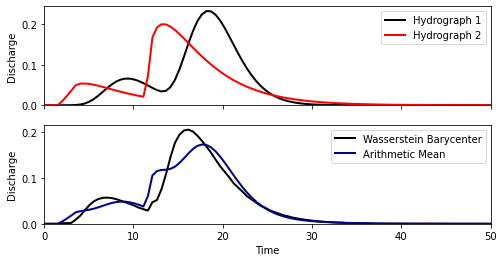

In [33]:
np.random.seed(32352)

times = np.linspace(0,50,100)
UH = hm.HydroModel(times,hm.Unit_Hydrograph)

r,r_n = hm.Simple_Rain(100,3)

h1 = UH(np.array([1,8]),r)
h2 = UH(np.array([4,1.5]),r)

fig, ax = plt.subplots(nrows=2,figsize=(8,4),sharex=True)
ax[0].plot(h1.t,h1.q,'-k',lw=2,label='Hydrograph 1')
ax[0].plot(h2.t,h2.q,'-r',lw=2,label='Hydrograph 2')

ax[0].set_ylabel('Discharge')
ax[0].set_xlim((0,50))
ax[0].set_ylim(bottom=0)

bary = hm.HydroBary([h1,h2])

ax[1].plot(bary.t,bary.q,color='black',lw=2,label='Wasserstein Barycenter')
ax[1].plot(h1.t,(h1.q+h2.q)/2,color='darkblue',lw=2,label='Arithmetic Mean')

ax[1].set_xlim((0,50))
ax[1].set_ylim(bottom=0)

ax[1].set_xlabel('Time')
ax[1].set_ylabel('Discharge')

ax[0].legend()
ax[1].legend()

plt.subplots_adjust(hspace=0.2)

plt.savefig('Figures/hydro_average.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/hydro_average.png',bbox_inches='tight',dpi=400)

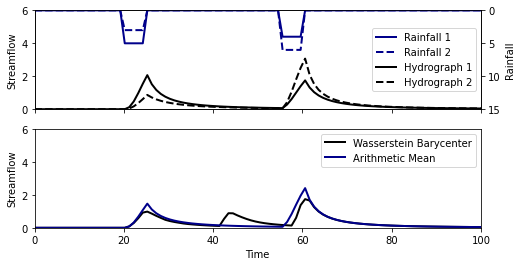

In [34]:
t = np.linspace(0,100,100)
NL = hm.HydroModel(t,hm.NonLinearHydro)

rain1 = np.zeros(100)
rain1[20:25] = 5
rain1[55:60] = 4

rain2 = np.zeros(100)
rain2[20:25] = 3
rain2[55:60] = 6

obs1 = NL([10,2,0.7],rain1)
obs2 = NL([10,2,0.7],rain2)

fig, ax = plt.subplots(nrows=2,figsize=(8,4),sharex=True,sharey=True)

hydr_1 = ax[0].plot(t,obs1.q,'-k',lw=2,label='Hydrograph 1')
hydr_2 = ax[0].plot(t,obs2.q,'--k',lw=2,label='Hydrograph 2')

ax2 = ax[0].twinx()
ax2.invert_yaxis()

rain_1 = ax2.plot(t,rain1,color='darkblue',lw=2,label='Rainfall 1')
rain_2 = ax2.plot(t,rain2,color='darkblue',lw=2,ls='--',label='Rainfall 2')
ax2.set_ylim((15,0))

ax[0].set_ylim((0,6))

ax[0].set_xlim((0,100))

ax[1].set_xlabel('Time')
ax[0].set_ylabel('Streamflow')
ax[1].set_ylabel('Streamflow')

ax2.set_ylabel('Rainfall')


ax[1].plot(t,hm.HydroBary([obs1,obs2]).q,'-k',lw=2,label='Wasserstein Barycenter')
ax[1].plot(t,(obs1.q+obs2.q)/2,color='darkblue',lw=2,label='Arithmetic Mean')


labs = [rain_1[0].get_label(),rain_2[0].get_label(),hydr_1[0].get_label(),hydr_2[0].get_label()]
ax[0].legend([rain_1[0],rain_2[0],hydr_1[0],hydr_2[0]], labs,loc=5)

ax[1].legend()

plt.subplots_adjust(hspace=0.2)

plt.savefig('Figures/poor_barycenter.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/poor_barycenter.png',bbox_inches='tight',dpi=400)

## Multivariate Motivation

While the computational method is more advanced, and the focus of the paper is univariate methods, many of the same concepts apply to multivariate problems. This is again valuable when our signal is displaced so has error in space rather than in ampltidue. Point-wise misfit functions give rise to the 'double penalty' effect, well known in atmospheric science. Without doing any Wasserstein calculations, we can quickly see the advantange of OT when studying the double penalty effect.

In [35]:
x = np.linspace(-1,1,200)
y = np.linspace(-1,1,200)

X,Y = np.meshgrid(x,y)
xy = np.column_stack((X.flatten(),Y.flatten()))

f = multivariate_normal.pdf(xy,mean=(-0.3,-0.3),cov=0.5*np.eye(2))
g = multivariate_normal.pdf(xy,mean=(0.3,0.3),cov=0.5*np.eye(2))

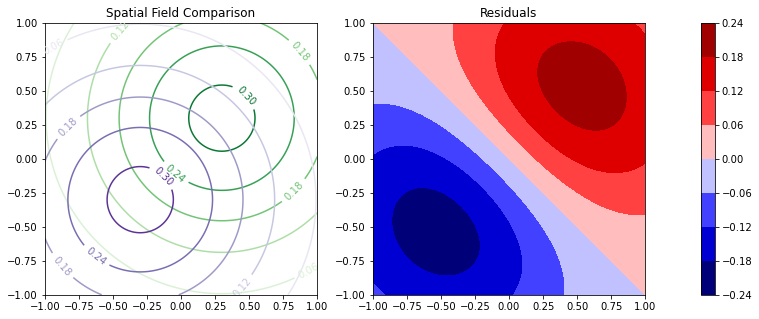

In [36]:
fig, ax = plt.subplots(ncols=3,figsize=(12,5),gridspec_kw={'width_ratios':[1,1,0.05],'wspace':0.3})
f1 = ax[0].contour(X,Y,g.reshape(200,200),cmap='Greens',levels=5)
f2 = ax[0].contour(X,Y,f.reshape(200,200),cmap='Purples',levels=5)
ax[0].set_title('Spatial Field Comparison')

plt.clabel(f1,inline=1)
plt.clabel(f2,inline=1)

resid = ax[1].contourf(X,Y,(g-f).reshape(200,200),cmap='seismic')
ax[1].set_title('Residuals')
cb = plt.colorbar(resid,cax=ax[2])

plt.savefig('Figures/spatial_res.pdf',bbox_inches='tight',dpi=400)
plt.savefig('Figures/spatial_res.png',bbox_inches='tight',dpi=400)